Ваша задача на этом соревновании - предсказать цены на квартиры в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и цены на квартиры) и test.csv (только признаки).

Описание датасета
Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

1) Подгружаем библиотеки для дальнейшей работы:

In [155]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime 

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

Напишем функцию для отображения информации и построения графиков предсказание тренировочного образца и тестового

In [ ]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Предсказание тренировочного образца')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Предсказание тестового образца')

    plt.show()

Для пропуска ошибок и отображения графиков без задействования всплывающих окон используем скрипты:

In [3]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Загрузжаем датасеты test.csv и train.csv для создания датафреймов testdf, traindf

In [4]:
testdf = pd.read_csv('test.csv')
traindf = pd.read_csv('train.csv')

In [5]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [6]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Следующий шаг: уменьшаем занимаемые объёмы памяти датасетами traindf и testdf

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = traindf.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
traindf = reduce_mem_usage(traindf)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.69 MB
Decreased by 55.0%


In [9]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int16  
 1   DistrictId     10000 non-null  int16  
 2   Rooms          10000 non-null  float32
 3   Square         10000 non-null  float32
 4   LifeSquare     7887 non-null   float32
 5   KitchenSquare  10000 non-null  float32
 6   Floor          10000 non-null  int8   
 7   HouseFloor     10000 non-null  float32
 8   HouseYear      10000 non-null  int32  
 9   Ecology_1      10000 non-null  float32
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int8   
 13  Social_2       10000 non-null  int16  
 14  Social_3       10000 non-null  int16  
 15  Healthcare_1   5202 non-null   float32
 16  Helthcare_2    10000 non-null  int8   
 17  Shops_1        10000 non-null  int8   
 18  Shops_2

In [10]:
testdf = reduce_mem_usage(testdf)

Memory usage of dataframe is 0.69 MB
Memory usage after optimization is: 0.31 MB
Decreased by 54.2%


In [11]:
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int16  
 1   DistrictId     5000 non-null   int16  
 2   Rooms          5000 non-null   float32
 3   Square         5000 non-null   float32
 4   LifeSquare     3959 non-null   float32
 5   KitchenSquare  5000 non-null   float32
 6   Floor          5000 non-null   int8   
 7   HouseFloor     5000 non-null   float32
 8   HouseYear      5000 non-null   int16  
 9   Ecology_1      5000 non-null   float32
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int8   
 13  Social_2       5000 non-null   int16  
 14  Social_3       5000 non-null   int16  
 15  Healthcare_1   2623 non-null   float32
 16  Helthcare_2    5000 non-null   int8   
 17  Shops_1        5000 non-null   int8   
 18  Shops_2 

In [170]:
testdf

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Healthcare_1_nan,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.000000,1970.0,0.036122,24,4378,0,1036.000000,1,1,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.000000,2017.0,0.072158,2,629,1,57.915904,0,0,1,0
2,960,27,2.0,59.463678,45.463678,9.0,19,19.000000,1977.0,0.211401,9,1892,0,57.915904,0,1,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,12.587313,1965.0,0.014073,2,475,0,57.915904,0,0,1,0
4,746,74,1.0,53.837056,43.837056,5.0,8,17.000000,1977.0,0.309479,35,7715,4,990.000000,0,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.000000,1962.0,0.069660,31,6119,4,57.915904,1,2,1,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.000000,2018.0,0.060753,15,2787,2,520.000000,0,7,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.000000,1966.0,0.038693,28,6533,1,1015.000000,2,5,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.000000,1970.0,0.089040,33,7976,5,57.915904,0,11,1,0


In [13]:
traindf

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [14]:
print('Строк в трейне:', traindf.shape[0])
print('Строк в тесте', testdf.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


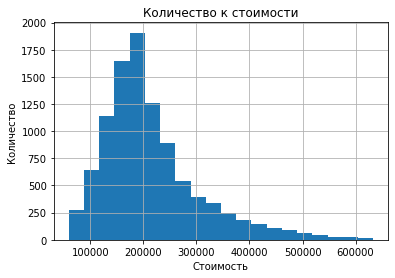

In [15]:
traindf['Price'].hist(bins=20)
plt.ylabel('Количество')
plt.xlabel('Стоимость')

plt.title('Количество к стоимости')
plt.show()

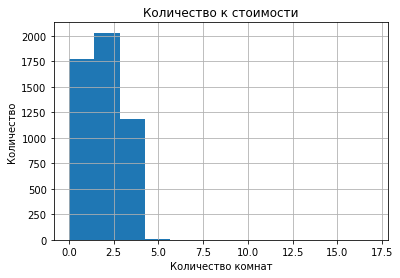

In [16]:
testdf['Rooms'].hist(bins=12)
plt.ylabel('Количество')
plt.xlabel('Количество комнат')

plt.title('Количество к стоимости')
plt.show()

In [17]:
testdf.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2'],
      dtype='object')

In [18]:
traindf.keys()

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')

In [19]:
traindf.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.859375
std,4859.01902,43.587592,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341,92872.289062
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


2) Проанализировав данные приходим к выводу, что столбцы Id и Districtid лучше приобразовать в другой тип данных,например str, так как они не повлияют на анализ данных:

In [20]:
traindf['Id'] = traindf['Id'].astype(str)
traindf['DistrictId'] = traindf['DistrictId'].astype(str)

In [21]:
traindf.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

3) Начинаем работать с данными столбца "Rooms":

In [22]:
traindf['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Проанализировав столбик указанный выше преобразовываем 0 в 1-комн.квартиру, а значения больше 6 комнат приведем к среднему:

In [23]:
traindf.loc[traindf['Rooms'] == 0, 'Rooms'] = 1
traindf.loc[traindf['Rooms'] >= 7, 'Rooms'] = traindf['Rooms'].median()

In [24]:
traindf['Rooms'].value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

Следующий столбик "Square":

In [25]:
traindf['Square'].describe()

count    10000.000000
mean        56.315777
std         21.058731
min          1.136859
25%         41.774879
50%         52.513309
75%         65.900627
max        641.065186
Name: Square, dtype: float64

С помощью .describe() видим что минимальное значение площади квартир состовляет 1.136859 м^2, что являеся нарушением СНиП 31-01-2003 ,а именно п.5.7. Поэтому согласно СНиП меняем min значения на 14 м^2 . Также приводим max значение к среднему

In [26]:
traindf.loc[traindf['Square'] <= 14, 'Square'] = 14
traindf.loc[traindf['Square'] >= 200, 'Square'] = traindf['Square'].mean()
traindf['Square'].describe()

count    10000.000000
mean        56.127537
std         18.872631
min         14.000000
25%         41.774879
50%         52.513309
75%         65.879387
max        198.930176
Name: Square, dtype: float64

Следующий столбик "LifeSquare" аналогично "Square":

In [27]:
traindf['LifeSquare'].describe()

count    7887.000000
mean       37.199646
std        86.241211
min         0.370619
25%        22.769833
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

С помощью .describe() видим что минимальное значение площади квартир состовляет 0.370619 м^2, что Для всей территории РФ размер минимальной жилплощади установлен в размере 6 кв. м при высоте потолка не ниже 210 см. приводим max значение к среднему

In [28]:
traindf.loc[traindf['LifeSquare']<=6,'LifeSquare'] = 6
traindf.loc[traindf['LifeSquare']>=180,'LifeSquare'] = traindf['LifeSquare'].mean()

In [29]:
traindf['LifeSquare'].describe()

count    7887.000000
mean       36.047749
std        17.357567
min         6.000000
25%        22.769833
50%        32.781261
75%        45.086464
max       174.837082
Name: LifeSquare, dtype: float64

Следующий столбик "KitchenSquare":

In [30]:
traindf['KitchenSquare'].describe()

count    10000.000000
mean         6.273300
std         28.560917
min          0.000000
25%          1.000000
50%          6.000000
75%          9.000000
max       2014.000000
Name: KitchenSquare, dtype: float64

С помощью .describe() видим что минимальное значение площади квартир состовляет  м^2, что Для всей территории РФ размер минимальной жилплощади установлен в размере не менее 5 кв. приводим max значение к среднему

In [31]:
traindf.loc[traindf['KitchenSquare'] < 5, 'KitchenSquare'] = 5
traindf.loc[traindf['KitchenSquare'] >= 60, 'KitchenSquare'] = traindf['KitchenSquare'].mean()

In [32]:
traindf['KitchenSquare'].describe()

count    10000.000000
mean         7.120723
std          2.991570
min          5.000000
25%          5.000000
50%          6.000000
75%          9.000000
max         58.000000
Name: KitchenSquare, dtype: float64

Следующий столбик "Floor":

In [33]:
traindf['Floor'].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [34]:
traindf['Floor'].value_counts()

4     949
5     876
3     872
6     802
7     759
8     643
9     604
2     588
10    553
11    457
12    438
13    398
14    362
16    290
15    287
17    256
1     235
18    185
19    121
20     68
21     59
22     54
24     53
25     34
23     25
26     18
27      5
28      3
32      2
42      1
37      1
33      1
31      1
Name: Floor, dtype: int64

Следующий столбик "HouseFloor":

In [35]:
traindf['HouseFloor'].describe()

count    10000.000000
mean        12.609400
std          6.775974
min          0.000000
25%          9.000000
50%         13.000000
75%         17.000000
max        117.000000
Name: HouseFloor, dtype: float64

In [36]:
traindf['HouseFloor'].value_counts()

17.0     2331
9.0      1389
12.0     1074
5.0      1031
14.0      625
16.0      576
1.0       497
25.0      374
22.0      343
0.0       269
24.0      176
8.0       141
10.0      135
4.0       134
3.0       127
15.0      123
19.0      108
20.0      105
18.0       89
7.0        59
6.0        58
2.0        48
23.0       40
21.0       33
11.0       28
13.0       27
30.0       21
40.0        7
27.0        6
37.0        4
32.0        4
28.0        3
39.0        2
48.0        2
99.0        2
29.0        1
44.0        1
47.0        1
36.0        1
31.0        1
38.0        1
117.0       1
45.0        1
26.0        1
Name: HouseFloor, dtype: int64

Из этих данных видим,что этажность дома отличается от этажа квартиры.Например: этажность дома максимальная 117, а одна из квартир находится на 42 этаже

!!!!!!!!Этажность дома не может быть нулевой, поэтому приводим данное значение к среднему и приводим максимальную этажность к 42этажам(В связи с тем что при использовании выражении "traindf['HouseFloor'] >= 42" получаем max = 40 , что не соответствует нашим условиям.Поэтомы мы подбираем ближайшее большее число чтобы максимальная этажность зданий была больше или равна 42( В нашем случае данное число 45, что соответствует max = 44)). Находим количество квартир у которых этажность дома больше этажности квартиры:

In [37]:
traindf.loc[traindf['HouseFloor'] <= 4, 'HouseFloor'] = traindf['HouseFloor'].mean()
traindf.loc[traindf['HouseFloor'] >= 45, 'HouseFloor'] = traindf['HouseFloor'].mean()
(traindf['Floor'] > traindf['HouseFloor']).value_counts()

False    8849
True     1151
dtype: int64

In [38]:
traindf['HouseFloor'].describe()

count    10000.000000
mean        13.773280
std          5.274522
min          5.000000
25%          9.000000
50%         13.000000
75%         17.000000
max         44.000000
Name: HouseFloor, dtype: float64

+Следующий столбик "HouseYear":

In [39]:
traindf['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

In [107]:
traindf.loc[traindf['HouseYear'] > datetime.now().year, 'HouseYear'] = traindf['HouseYear'].mean()

In [41]:
traindf['HouseYear'].value_counts()

1977.0    2652
2017.0     308
2016.0     305
2015.0     299
2014.0     210
          ... 
1910.0       1
1947.0       1
1928.0       1
1916.0       1
1914.0       1
Name: HouseYear, Length: 96, dtype: int64

3)Следующим шагом будет поиск и обработка пропусках в наших данных

In [42]:
traindf.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

LifeSquare:

In [43]:
traindf['LifeSquare_nan'] = traindf['LifeSquare'].isna() * 1

condition = (traindf['LifeSquare'].isna()) \
             & (~traindf['Square'].isna()) \
             & (~traindf['KitchenSquare'].isna())
        
traindf.loc[condition, 'LifeSquare'] = traindf.loc[condition, 'Square'] \
                                            - traindf.loc[condition, 'KitchenSquare'] - 5

Healthcare_1 

In [44]:
traindf['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.517273
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

traindf['Healthcare_1'] = traindf['Healthcare_1'].isna() * 1

condition = traindf['Healthcare_1'].mean()
 
traindf.loc[condition, 'Healthcare_1'] = traindf['Healthcare_1'].mean() 

In [45]:
traindf['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.517273
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [46]:
traindf.loc[traindf['Healthcare_1'] == "NaN", 'Healthcare_1'] = traindf['Healthcare_1'].mean()

In [47]:
traindf['Healthcare_1'].describe()

count    5202.000000
mean     1142.904419
std      1021.517273
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [48]:
traindf[['Healthcare_1', 'Helthcare_2', 'Social_1', 'Social_2', 'Social_3']].value_counts()

Healthcare_1  Helthcare_2  Social_1  Social_2  Social_3
540.0         0            5         1564      0           511
1046.0        3            22        6398      141         245
30.0          2            25        5648      1           202
750.0         2            34        7065      1           163
229.0         1            34        7759      0           148
                                                          ... 
32.0          0            8         2423      1            12
1815.0        2            16        3681      73           10
562.0         1            8         1423      37            3
35.0          0            3         662       0             2
0.0           0            2         528       0             1
Length: 84, dtype: int64

In [53]:
traindf[['DistrictId','Healthcare_1']].value_counts()

DistrictId  Healthcare_1
6           540.0           511
30          1046.0          228
9           30.0            202
53          229.0           146
52          750.0           143
                           ... 
69          620.0             1
43          628.0             1
182         2890.0            1
181         4702.0            1
59          620.0             1
Length: 285, dtype: int64

In [55]:
traindf['Healthcare_1_nan'] = traindf['Healthcare_1'].isna() * 1
condition = (traindf['Healthcare_1'].isna()) \
             & (~traindf['DistrictId'].isna()) 
        
traindf.loc[condition, 'Healthcare_1'] = traindf.loc[condition, 'Square'].mean()

In [56]:
traindf['Healthcare_1'].describe()

count    10000.000000
mean       621.861877
std        914.959961
min          0.000000
25%         56.946541
50%         56.946541
75%        990.000000
max       4849.000000
Name: Healthcare_1, dtype: float64

Проверяем наш датафрейм trainfd  на пропуски:

In [57]:
traindf.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1        0
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
LifeSquare_nan      0
Healthcare_1_nan    0
dtype: int64

Ударяем вспомогательные столики LifeSquare_nan и Healthcare_1_nan

In [62]:
traindf.drop('Healthcare_1_nan', axis=1, inplace=True)
traindf.drop('LifeSquare_nan', axis=1, inplace=True)

In [63]:
traindf.isna().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

4) Создаём класс DataPreprocessing для дальнейшей оптимизации нашего процесса:

In [126]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.means = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет среднего
        self.means = X.mean()
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms !!!!!!!!!!!
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 7, 'Rooms'] = self.means['Rooms']
        
        # KitchenSquare !!!!!!!!!!!
        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        X.loc[X['KitchenSquare'] >= 60, 'KitchenSquare'] = self.means['KitchenSquare']
        
        # HouseFloor, Floor !!!!!!!!!!!
        X.loc[X['HouseFloor'] <= 4, 'HouseFloor'] = self.means['HouseFloor']
        X.loc[X['HouseFloor'] >= 45, 'HouseFloor'] = self.means['HouseFloor']
        
        # HouseYear !!!!!!!!!!!   
        X.loc[X['HouseYear'] > datetime.now().year, 'HouseYear'] = self.means['HouseYear']
        
        # Healthcare_1 !!!!!!!!!!!
        X['Healthcare_1_nan'] = X['Healthcare_1'].isna() * 1
        condition = (X['Healthcare_1'].isna()) \
                     & (~X['DistrictId'].isna()) 
        
        X.loc[condition, 'Healthcare_1'] = X.loc[condition, 'Square'].mean()
            
        # LifeSquare !!!!!!!!!!!
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 5
        
        X.drop('Ecology_2', axis=1, inplace=True)
        X.drop('Ecology_3', axis=1, inplace=True)
        X.drop('Shops_2', axis=1, inplace=True)
        
        X.fillna(self.means, inplace=True)
        
        return X

In [128]:
target_name = 'Price'

5) Разбиваем на тренировочные,валидационные и тестовые модели

In [129]:
testdf = pd.read_csv('test.csv')
traindf = pd.read_csv('train.csv')

X = traindf.drop(columns=target_name)
y = traindf[target_name]

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [131]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
testdf = preprocessor.transform(testdf)

X_train.shape, X_valid.shape, testdf.shape

((6700, 18), (3300, 18), (5000, 18))

6) Построение модели

In [137]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=21)

Train R2:	0.959
Test R2:	0.734


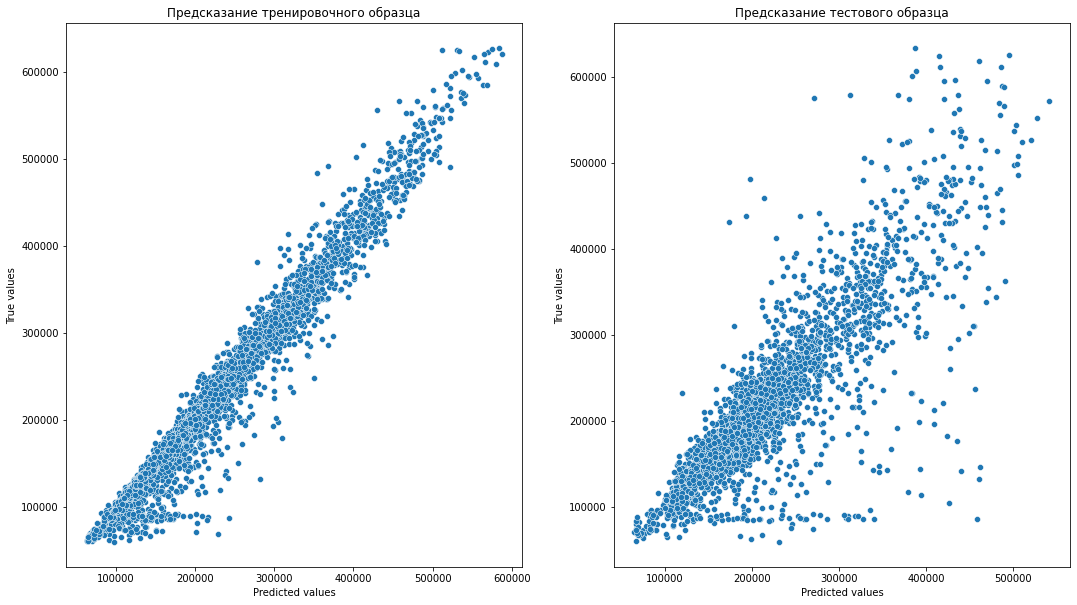

In [150]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

7) Кросс-валидация данных

In [160]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.72271107, 0.66063141, 0.71405835])

In [157]:
cv_score.mean()

0.6991336112379337

In [165]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,Square,0.374574
10,Social_1,0.098039
11,Social_2,0.096546
2,Rooms,0.082274
12,Social_3,0.050632
1,DistrictId,0.048301
4,LifeSquare,0.035991
9,Ecology_1,0.035691
8,HouseYear,0.034404
6,Floor,0.025377


По результатам отображения важности параметров нашего датасета, делаем вывод что ни один из параметр не будет отброшен (так как важность 0 и более 50 отсутствуют)

8) Прогнозирование на тестовом датасете

In [167]:
testdf.shape

(5000, 18)

In [168]:
testdf

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Healthcare_1_nan,LifeSquare_nan
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.000000,1970.0,0.036122,24,4378,0,1036.000000,1,1,0,0
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.000000,2017.0,0.072158,2,629,1,57.915904,0,0,1,0
2,960,27,2.0,59.463678,45.463678,9.0,19,19.000000,1977.0,0.211401,9,1892,0,57.915904,0,1,1,1
3,3848,23,3.0,49.646030,33.893825,6.0,2,12.587313,1965.0,0.014073,2,475,0,57.915904,0,0,1,0
4,746,74,1.0,53.837056,43.837056,5.0,8,17.000000,1977.0,0.309479,35,7715,4,990.000000,0,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.000000,1962.0,0.069660,31,6119,4,57.915904,1,2,1,0
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.000000,2018.0,0.060753,15,2787,2,520.000000,0,7,0,0
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.000000,1966.0,0.038693,28,6533,1,1015.000000,2,5,0,0
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.000000,1970.0,0.089040,33,7976,5,57.915904,0,11,1,0


In [172]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [174]:
predictions = rf_model.predict(testdf)
predictions

array([164941.36939144, 113859.74000226, 140951.89482482, ...,
       147100.82528062, 188246.71734723, 279673.03108833])

In [175]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,164941.369391
1,5925,113859.740002
2,960,140951.894825
3,3848,121664.532009
4,746,208510.371948


In [176]:
submit.to_csv('rf_submit.csv', index=False)